In [ ]:
!pip install requests
!pip install openpyxl
!pip install xlrd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import re
import os

In [ ]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales
uk_2015_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2015/publishedweek2015.xls'
uk_2016_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2016/publishedweek522016.xls'
uk_2017_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2017/publishedweek522017.xls'
uk_2018_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2018/publishedweek522018withupdatedrespiratoryrow.xls'
uk_2019_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2019/publishedweek522019.xls'
uk_2020_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek532020.xlsx'
uk_2021_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2021/publishedweek4820211.xlsx'


# https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/11485fiveyearaverageweeklydeathsbysexandagegroupenglandandwalesdeathsoccurringbetween2015and2019
uk_2015_2019_url = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/11485fiveyearaverageweeklydeathsbysexandagegroupenglandandwalesdeathsoccurringbetween2015and2019/fiveyearavgweeklydeaths2015to2019.xlsx'

In [ ]:
def get_filename_from_url(url):
    idx = url.rfind('/')
    return url[idx+1:]

In [ ]:
def load_file(url, sheet_idx):
    filename = 'data/' + get_filename_from_url(url)
    if not os.path.exists(filename):
        print(f"Downloading {url}...")
        r = requests.get(url, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    return pd.read_excel(filename, sheet_name=sheet_idx)



In [ ]:
def fix_old_format(df_old, year, idx_name='Unnamed: 1'):
    
    df_old = df_old.rename(columns={idx_name: 'Age'})
    df_old = df_old.set_index('Age')

    df_old.loc['00-14', :] = df_old.loc['Under 1 year'] + df_old.loc['01-14']
    # TEMP: escludo neonati
    #df_old.loc['00-14', :] = df_old.loc['01-14']
    df_old = df_old.drop('Under 1 year')
    df_old = df_old.drop('01-14')

    # move column top
    df_old["new"] = range(1,len(df_old)+1)
    df_old.loc[df_old.index=='00-14', 'new'] = 0
    df_old = df_old.sort_values("new").drop('new', axis=1)
    
    df_old = df_old.astype(int)
    
    # rename weeks
    lst = list(df_old.columns)
    lst = ['Week {}'.format(x+1) for x in range(len(lst))] 
    df_old.columns = lst    

    # drop partial weeks
    df_old = df_old.loc[:, 'Week 2':'Week 50']
    #print(df_old.columns)
    
    # add year on front
    df_old = df_old.assign(Year=year)
    col = df_old.pop("Year")
    df_old.insert(0, col.name, col)

    return df_old


In [ ]:
load_file(uk_2015_url, 3)[23:30]

In [ ]:
uk_2015 = load_file(uk_2015_url, 3)
uk_2016 = load_file(uk_2016_url, 3)
uk_2017 = load_file(uk_2017_url, 3)
uk_2018 = load_file(uk_2018_url, 3)
uk_2019 = load_file(uk_2019_url, 3)

uk_2015_males = uk_2015.iloc[23:30]
uk_2016_males = uk_2016.iloc[23:30, 1:]
uk_2017_males = uk_2017.iloc[23:30, 1:]
uk_2018_males = uk_2018.iloc[23:30, 1:]
uk_2019_males = uk_2019.iloc[23:30, 1:]

uk_2015_males = fix_old_format(uk_2015_males, 2015, idx_name='Contents')
uk_2016_males = fix_old_format(uk_2016_males, 2016)
uk_2017_males = fix_old_format(uk_2017_males, 2017)
uk_2018_males = fix_old_format(uk_2018_males, 2018)
uk_2019_males = fix_old_format(uk_2019_males, 2019)

uk_2015_males




In [ ]:
def sum_rows(df, new_col_name, src_cols):
    df.loc[new_col_name, :] = df.loc[src_cols].sum()
    return df.drop(src_cols)
        
def fix_new_format(df_new, year):
    
    df_new = df_new.rename(columns={"Unnamed: 1": 'Age'})
    df_new = df_new.set_index('Age')

    df_new = sum_rows(df_new, '00-14', ['<1', '1-4', '5-9', '10-14'])
    # TEMP: escludo neonati
    #df_new = sum_rows(df_new, '00-14', ['1-4', '5-9', '10-14'])
    #df_new = df_new.drop('<1')
    
    df_new = sum_rows(df_new, '15-44', ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44'])
    df_new = sum_rows(df_new, '45-64', ['45-49', '50-54', '55-59', '60-64'])
    df_new = sum_rows(df_new, '65-74', ['65-69', '70-74'])
    df_new = sum_rows(df_new, '75-84', ['75-79', '80-84'])
    df_new = sum_rows(df_new, '85+',   ['85-89', '90+'])

    df_new = df_new.astype(int)
    
    # rename columns
    lst = list(df_new.columns)
    lst = ['Week {}'.format(x+1) for x in range(len(lst))] 
    df_new.columns = lst    

    # drop border columns (may be partial and not in every year)
    df_new = df_new.loc[:, 'Week 2':'Week 50']

    # add year column
    df_new = df_new.assign(Year=year)
    col = df_new.pop("Year")
    df_new.insert(0, col.name, col)
    
    return df_new


In [ ]:
uk_2020 = load_file(uk_2020_url, 4)

uk_2020_males_fine = uk_2020.iloc[42:62, 1:]
uk_2020_males = fix_new_format(uk_2020_males_fine, 2020)

uk_2021 = load_file(uk_2021_url, 4)

uk_2021_males_fine = uk_2021.iloc[38:58, 1:]
uk_2021_males = fix_new_format(uk_2021_males_fine, 2021)

#uk_2021_males


In [ ]:
# average (males only, even if not in the name...)

uk_2015_2019_avg = pd.concat([uk_2015_males, uk_2016_males, uk_2017_males, uk_2018_males, uk_2019_males]).groupby(level=0).mean()

uk_2015_2019_std = pd.concat([uk_2015_males, uk_2016_males, uk_2017_males, uk_2018_males, uk_2019_males]).groupby(level=0).std()

uk_2015_2019_avg['Year'] = 0
uk_2015_2019_std['Year'] = 1

uk_2015_2019_avg

In [ ]:
# mean and std on 2015_2019 average

uk_2015_2019_avg_MA = uk_2015_2019_avg.iloc[:,1:].rolling(axis=1, window=4).mean()
uk_2015_2019_std_MA = uk_2015_2019_std.iloc[:,1:].rolling(axis=1, window=4).mean()

uk_2015_2019_avg_MA

In [ ]:
# compare averages
uk_2015_2019_official_avg = load_file(uk_2015_2019_url, 1).iloc[2:21, 1:]

uk_2015_2019_official_avg = uk_2015_2019_official_avg.rename(columns={"Unnamed: 1": 'Age'})
uk_2015_2019_official_avg = uk_2015_2019_official_avg.set_index('Age')

uk_2015_2019_official_avg = sum_rows(uk_2015_2019_official_avg, '00-14', ['00-04', '05-09', '10-14'])
uk_2015_2019_official_avg = sum_rows(uk_2015_2019_official_avg, '15-44', ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44'])
uk_2015_2019_official_avg = sum_rows(uk_2015_2019_official_avg, '45-64', ['45-49', '50-54', '55-59', '60-64'])
uk_2015_2019_official_avg = sum_rows(uk_2015_2019_official_avg, '65-74', ['65-69', '70-74'])
uk_2015_2019_official_avg = sum_rows(uk_2015_2019_official_avg, '75-84', ['75-79', '80-84'])
uk_2015_2019_official_avg = sum_rows(uk_2015_2019_official_avg, '85+',   ['85-89', '90+'])

uk_2015_2019_official_avg = uk_2015_2019_official_avg.astype(int)

# rename columns
lst = list(uk_2015_2019_official_avg.columns)
lst = ['Week {}'.format(x+1) for x in range(len(lst))] 
uk_2015_2019_official_avg.columns = lst    

# drop border columns (may be partial and not in every year)
uk_2015_2019_official_avg = uk_2015_2019_official_avg.loc[:, 'Week 2':'Week 50']

# add year column
uk_2015_2019_official_avg = uk_2015_2019_official_avg.assign(Year=999)
col = uk_2015_2019_official_avg.pop("Year")
uk_2015_2019_official_avg.insert(0, col.name, col)



uk_2015_2019_official_avg

In [ ]:
plt.rcParams["figure.figsize"] = (30,20)

# validate computed average against official data

plt.figure()

plt.plot(uk_2015_2019_official_avg.loc['00-14'][1:], 'g', label=f"Official")
plt.plot(uk_2015_2019_avg.loc['00-14'][1:], 'b', label=f"Computed")

plt.plot(uk_2015_2019_official_avg.loc['45-64'][1:], 'g', label=f"Official")
plt.plot(uk_2015_2019_avg.loc['45-64'][1:], 'b', label=f"Computed")

plt.plot(uk_2015_2019_official_avg.loc['85+'][1:], 'g', label=f"Official")
plt.plot(uk_2015_2019_avg.loc['85+'][1:], 'b', label=f"Computed")

# std
ma = uk_2015_2019_avg_MA.loc['00-14', 'Week 2':]
mstd = uk_2015_2019_std_MA.loc['00-14', 'Week 2':]
plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")

ma = uk_2015_2019_avg_MA.loc['45-64', 'Week 2':]
mstd = uk_2015_2019_std_MA.loc['45-64', 'Week 2':]
plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")

ma = uk_2015_2019_avg_MA.loc['85+', 'Week 2':]
mstd = uk_2015_2019_std_MA.loc['85+', 'Week 2':]
plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")

plt.savefig(f"results/averages_comparison.png", facecolor='white', transparent=False)


plt.show()

In [ ]:
uk_2021_males

In [ ]:
uk_2015_2019_avg

In [ ]:
uk_2015_2019_std

In [ ]:
datasets = {2015: uk_2015_males, 
           2016: uk_2016_males,
           2017: uk_2017_males,
           2018: uk_2018_males,
           2019: uk_2019_males,
           2020: uk_2020_males,
           2021: uk_2021_males}

datasets_2015_2019 = {2015: uk_2015_males, 
           2016: uk_2016_males,
           2017: uk_2017_males,
           2018: uk_2018_males,
           2019: uk_2019_males}

datasets_2020_2021 = {2020: uk_2020_males,
           2021: uk_2021_males}

In [ ]:
#uk_2021_males_MA = uk_2021_males.iloc[:,1:].rolling(axis=1, window=4).mean()

#uk_2021_males_MA.loc['15-44', 'Week 2':'Week 47'].plot()
#uk_2015_2019_avg_MA.loc['15-44', 'Week 2':].plot()
#plt.plot([1, 2, 3, 4])
#plt.ylabel('some numbers')
#plt.show()


In [ ]:

end_week = 'Week 48'
#end_week = 'Week 50'

ages = ['00-14', '15-44', '45-64', '65-74', '75-84', '85+']
colors = ['k', 'm', 'c', 'g', 'y', 'b', 'r']

#uk_2015_2019_avg_MA = uk_2015_2019_avg.iloc[:,1:].rolling(axis=1, window=4).mean()
#uk_2015_2019_std_MA = uk_2015_2019_std.iloc[:,1:].rolling(axis=1, window=4).mean()

for year,df_src in datasets.items():
    
    for age in ages:

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]
        #avg_val = uk_2015_2019_avg.loc[age, 'Week 2':]

        ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':]
        mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':]

        plt.figure()

        plt.plot(val_MA.index, val_MA, 'k', alpha=1, label=f"{year} (MA4)")

        plt.plot(val.index, val, 'k', alpha=0.2, label=year)
        plt.plot(ma.index, ma, 'lime', label="2015-2019 Avg", lw=3)
        plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")
        plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.04, label="2 std")
        plt.fill_between(mstd.index, ma-4*mstd, ma+4*mstd, color='b', alpha=0.04, label="4 std")

        plt.title(f"{year} all causes mortality {age} males vs 2015-2019 average")

        plt.xticks(rotation=90)
        plt.legend()

        plt.grid()
        plt.tight_layout()
        
        plt.savefig(f"results/chart_{year}_{age}.png", facecolor='white', transparent=False)

        plt.show()




In [ ]:

ylims = [(20, 55), (150, 300), (600, 1400), (800, 2000), (1000, 3500), (1000, 3800)]

for age, yl in zip(ages, ylims):

    plt.figure()

    for (year,df_src), color in zip(datasets.items(), colors):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]
        #avg_val = uk_2015_2019_avg.loc[age, 'Week 2':]

        ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':]
        mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':]

        #plt.plot(val.index, val, color, alpha=0.2, label=year)
        plt.plot(val_MA.index, val_MA, color, alpha=1, label=f"{year} (MA4)")
        
    plt.plot(ma.index, ma, 'lime', label="2015-2019 Avg (MA4)", lw=3)
    plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")
    plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(mstd.index, ma-4*mstd, ma+4*mstd, color='b', alpha=0.04, label="4 std")
    plt.fill_between(mstd.index, ma-8*mstd, ma+8*mstd, color='g', alpha=0.04, label="8 std")
    plt.fill_between(mstd.index, ma-16*mstd, ma+16*mstd, color='y', alpha=0.04, label="16 std")

    plt.title(f"All causes mortality {age} males vs 2015-2019 average (MA 4 weeks)")

    plt.xticks(rotation=90)
    plt.legend()
    
    plt.ylim(yl)

    plt.grid()
    plt.tight_layout()

    plt.savefig(f"results/chart_age_{age}.png", facecolor='white', transparent=False)

    plt.show()


In [ ]:
# 2015-2019 only (per verifica)

for age in ages:

    plt.figure()

    for (year,df_src), color in zip(datasets_2015_2019.items(), colors):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]
        #avg_val = uk_2015_2019_avg.loc[age, 'Week 2':]

        ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':]
        mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':]

        #plt.plot(val.index, val, color, alpha=0.2, label=year)
        plt.plot(val_MA.index, val_MA, color, alpha=1, label=f"{year} (MA4)")
        
    plt.plot(ma.index, ma, 'lime', label="2015-2019 Avg (MA4)", lw=3)
    plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")
    plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.04, label="2 std")
    #plt.fill_between(mstd.index, ma-4*mstd, ma+4*mstd, color='b', alpha=0.04, label="4 std")
    #plt.fill_between(mstd.index, ma-8*mstd, ma+8*mstd, color='g', alpha=0.04, label="8 std")
    #plt.fill_between(mstd.index, ma-16*mstd, ma+16*mstd, color='y', alpha=0.04, label="16 std")

    plt.title(f"2015-2019 all causes mortality {age} males vs 2015-2019 average (MA 4 weeks)")

    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()

    plt.savefig(f"results/chart_age_2015_2019_{age}.png", facecolor='white', transparent=False)

    plt.show()


In [ ]:
# subtract average to remove seasonality

ylims = [(-15, 15), (-30, 50), (-100, 700), (-100, 1000), (-250, 2000), (-350, 2100)]

for age, yl in zip(ages, ylims):

    ax = plt.figure()

    for (year,df_src), color in zip(datasets.items(), colors):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]
        #avg_val = uk_2015_2019_avg.loc[age, 'Week 2':]

        ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':end_week]
        mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':end_week]

        #plt.plot(val.index, val, color, alpha=0.2, label=year)
        diff = val_MA - ma
        plt.plot(val_MA.index, diff, color, alpha=1, label=f"{year} (MA4)")


    #plt.plot(ma.index, ma, 'lime', label="2015-2019 Avg (MA4)", lw=4)
    plt.fill_between(mstd.index, -1*mstd, 1*mstd, color='b', alpha=0.05, label="1 std")
    plt.fill_between(mstd.index, -2*mstd, 2*mstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(mstd.index, -4*mstd, 4*mstd, color='b', alpha=0.04, label="4 std")
    plt.fill_between(mstd.index, -8*mstd, 8*mstd, color='g', alpha=0.04, label="8 std")
    plt.fill_between(mstd.index, -16*mstd, 16*mstd, color='y', alpha=0.04, label="16 std")
    
    plt.ylim(yl)
    
    plt.title(f"2015-2021 difference in all causes mortality {age} males vs 2015-2019 average (MA 4 weeks)")

    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()

    plt.savefig(f"results/diff_chart_age_{age}.png", facecolor='white', transparent=False)

    plt.show()

In [ ]:

#uk_2015_2019_avg_MA = uk_2015_2019_avg.iloc[:,1:].rolling(axis=1, window=4).mean()
#uk_2015_2019_std_MA = uk_2015_2019_std.iloc[:,1:].rolling(axis=1, window=4).mean()


for year,df_src in datasets.items():

    plt.figure()

    for age, color in zip(ages, colors):

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()

        val = df_src.loc[age, 'Week 2':end_week]
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]

        #print(ma)
        #print(val_MA)
        ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':end_week]

        change = 100 * (val_MA - ma) / ma

        #print(change)

        plt.plot(change.index, change, color, alpha=1, label=f"{age} (MA4)")
        if color == 'r':
            plt.fill_between(mstd.index, [20] * 46, [-20] * 46, color='b', alpha=0.04)
            plt.fill_between(mstd.index, [10] * 46, [-10] * 46, color='b', alpha=0.03)

    plt.title(f"Percentage change in {year} all causes mortality males vs 2015-2019 average (MA 4 weeks)")

    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()

    plt.savefig(f"results/perc_chart_{year}.png", facecolor='white', transparent=False)

    plt.show()


In [ ]:
# cumulativi

uk_2015_2019_avg_cum = uk_2015_2019_avg.iloc[:, 1:].cumsum(axis=1)

#end_week = 'Week 47'
all_cum = None
for year,df in datasets_2015_2019.items():
    df_cum = df.iloc[:,1:].cumsum(axis=1)
    
    if all_cum is None:
        all_cum = df_cum
    else:
        all_cum = pd.concat([all_cum, df_cum])

cum_2015_2019_mean = all_cum.groupby('Age').mean()
cum_2015_2019_std = all_cum.groupby('Age').std()


cum_2015_2019_mean
cum_2015_2019_std



In [ ]:

plt.figure()

#end_week = 'Week 47'
for age in ages:
    for (year,df),color in zip(datasets_2020_2021.items(), ['b', 'r']):

        print(year, color)
        df_cum = df.iloc[:, 1:].cumsum(axis=1)

        val = df_cum.loc[age, 'Week 2':end_week]
        plt.plot(val.index, val, color, alpha=1, label = year)

    avg = cum_2015_2019_mean.loc[age, 'Week 2':end_week]
    ax = plt.plot(avg.index, avg, 'lime', alpha=1, label = '2015-2019 Avg', lw=3)
    #print(ax)
    
    cstd = cum_2015_2019_std.loc[age, 'Week 2':end_week]
    #print(cstd)

    plt.fill_between(cstd.index, avg-1*cstd, avg+1*cstd, color='b', alpha=0.04, label="1 std")
    plt.fill_between(cstd.index, avg-2*cstd, avg+2*cstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(cstd.index, avg-4*cstd, avg+4*cstd, color='b', alpha=0.05, label="4 std")
    plt.fill_between(cstd.index, avg-8*cstd, avg+8*cstd, color='g', alpha=0.05, label="8 std")
    plt.fill_between(cstd.index, avg-16*cstd, avg+16*cstd, color='y', alpha=0.05, label="16 std")
    
    plt.title(f"2015-2019 all causes mortality {age} males vs 2015-2019 average")
    
    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()
    
    plt.savefig(f"results/cumulative_2015-2019_{age}.png", facecolor='white', transparent=False)
        
    plt.show()


In [ ]:
ax = plt.figure()

ylims = [(-250, 150), (-250, 1100), (-1000, 7500), (-1500, 6500), (-2000, 15000), (-3500, 15000)]

#end_week = 'Week 47'
for age, yl in zip(ages, ylims):

    avg = cum_2015_2019_mean.loc[age, 'Week 2':end_week]
    # yes, this is all zero
    ax = plt.plot(avg.index, avg-avg, 'lime', alpha=1, label = '2015-2019 Avg', lw=2)
    
    cstd = cum_2015_2019_std.loc[age, 'Week 2':end_week]
    #print(cstd)

    plt.fill_between(cstd.index, -1*cstd, 1*cstd, color='b', alpha=0.04, label="1 std")
    plt.fill_between(cstd.index, -2*cstd, 2*cstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(cstd.index, -4*cstd, 4*cstd, color='b', alpha=0.05, label="4 std")
    plt.fill_between(cstd.index, -8*cstd, 8*cstd, color='g', alpha=0.05, label="8 std")
    plt.fill_between(cstd.index, -16*cstd, 16*cstd, color='y', alpha=0.05, label="16 std")

    for (year,df),color in zip(datasets.items(), colors):

        print(year, color)
        df_cum = df.iloc[:, 1:].cumsum(axis=1)

        val = df_cum.loc[age, 'Week 2':end_week]
        
        diff = val - avg
        
        plt.plot(diff.index, diff, color, alpha=1, label = year)
        
        #plt.plot(diff.index, diff, color, alpha=1, label = year)
        
        #cstd = cum_2015_2019_std.loc[age, 'Week 2':end_week]
        #plt.plot(cstd.index, cstd, 'o', alpha=1, label = year)

    
    plt.ylim(yl)
    
    plt.title(f"2020/2021 difference in cumulative all causes mortality {age} males vs 2015-2019 average")
    
    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()
    
    plt.savefig(f"results/cumulative_diff_{year}_{age}.png", facecolor='white', transparent=False)
        
    plt.show()
    #break


In [ ]:
# for comparison and validation

plt.figure()

#end_week = 'Week 47'
for age in ages:
    for (year,df),color in zip(datasets_2015_2019.items(), colors):

        print(year, color)
        df_cum = df.iloc[:, 1:].cumsum(axis=1)

        val = df_cum.loc[age, 'Week 2':end_week]
        plt.plot(val.index, val, color, alpha=1, label = year)

    avg = cum_2015_2019_mean.loc[age, 'Week 2':end_week]
    ax = plt.plot(avg.index, avg, 'lime', alpha=1, label = '2015-2019 Avg', lw=3)
    #print(ax)
    
    cstd = cum_2015_2019_std.loc[age, 'Week 2':end_week]
    #print(cstd)

    plt.fill_between(cstd.index, avg-1*cstd, avg+1*cstd, color='b', alpha=0.04, label="1 std")
    plt.fill_between(cstd.index, avg-2*cstd, avg+2*cstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(cstd.index, avg-4*cstd, avg+4*cstd, color='b', alpha=0.05, label="4 std")
    
    plt.title(f"2015/2019 all causes mortality {age} males vs 2015-2019 average")
    
    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()
    
    plt.savefig(f"results/cumulative_{year}_{age}.png", facecolor='white', transparent=False)
        
    plt.show()

In [ ]:
uk_2020_covid = load_file(uk_2020_url, 5)
uk_2020_covid_males_fine = uk_2020_covid.iloc[32:52, 1:]
uk_2020_covid_males = fix_new_format(uk_2020_covid_males_fine, 2020)

uk_2021_covid = load_file(uk_2021_url, 6)
uk_2021_covid_males_fine = uk_2021_covid.iloc[32:52, 1:]
uk_2021_covid_males = fix_new_format(uk_2021_covid_males_fine, 2021)

uk_2020_covid_males

# tot: 73141 caused by: 63594  86.95%

In [ ]:
uk_2020_males

In [ ]:
uk_2020_covid_males

In [ ]:
uk_2020_non_covid_males = uk_2020_males - uk_2020_covid_males
uk_2021_non_covid_males = uk_2021_males - uk_2021_covid_males

datasets_non_covid_2020_2021 = {2020: uk_2020_non_covid_males,
           2021: uk_2021_non_covid_males}

datasets_covid_2020_2021 = {2020: uk_2020_covid_males,
           2021: uk_2021_covid_males}

uk_2021_non_covid_males

In [ ]:
uk_2021_covid_males

In [ ]:
uk_2015_2019_avg_MA

In [ ]:
# non covid by age

ylims = [(20, 50), (150, 260), (600, 1400), (800, 2000), (1000, 3500), (1000, 3800)]

for age, yl in zip(ages, ylims):

    plt.figure()

    for (year,df_src), color in zip(datasets_2020_2021.items(), ['b', 'r']):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]
        #avg_val = uk_2015_2019_avg.loc[age, 'Week 2':]

        #ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':]
        #mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':]

        #plt.plot(val.index, val, color, alpha=0.2, label=year)
        plt.plot(val_MA.index, val_MA, color, linestyle='dashed', alpha=0.5, label=f"{year} all causes (MA4)")

    for (year,df_src), color in zip(datasets_non_covid_2020_2021.items(), ['b', 'r']):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]
        #avg_val = uk_2015_2019_avg.loc[age, 'Week 2':]

        #ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':]
        #mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':]

        #plt.plot(val.index, val, color, alpha=0.2, label=year)
        plt.plot(val_MA.index, val_MA, color, alpha=1, label=f"{year} non covid (MA4)")

    # NOTA: uso la deviazione standard 2015-2019 solo come riferimento
    ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':end_week]
    plt.plot(ma.index, ma, 'lime', label="2015-2019 Avg (MA4)", lw=3)
    plt.fill_between(mstd.index, ma-1*mstd, ma+1*mstd, color='b', alpha=0.05, label="1 std")
    plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(mstd.index, ma-4*mstd, ma+4*mstd, color='b', alpha=0.04, label="4 std")
    plt.fill_between(mstd.index, ma-8*mstd, ma+8*mstd, color='g', alpha=0.04, label="8 std")
    plt.fill_between(mstd.index, ma-16*mstd, ma+16*mstd, color='y', alpha=0.04, label="16 std")

    plt.title(f"Non covid mortality {age} males (MA 4 weeks)")

    plt.xticks(rotation=90)
    plt.legend()
    
    plt.ylim(yl)

    plt.grid()
    plt.tight_layout()

    plt.savefig(f"results/non_covid_age_{age}.png", facecolor='white', transparent=False)

    plt.show()

In [ ]:
# cumulative diff non-covid

ax = plt.figure()

ylims = [(-250, 125), (-400, 1200), (-1000, 7200), (-3000, 7500), (-5000, 14000), (-7000, 15000)]

#end_week = 'Week 47'
for age, yl in zip(ages, ylims):

    avg = cum_2015_2019_mean.loc[age, 'Week 2':end_week]
    # yes, this is all zero
    ax = plt.plot(avg.index, avg-avg, 'lime', alpha=1, label = '2015-2019 Avg', lw=2)
    
    cstd = cum_2015_2019_std.loc[age, 'Week 2':end_week]
    #print(cstd)
    

    plt.fill_between(cstd.index, -1*cstd, 1*cstd, color='b', alpha=0.04, label="1 std")
    plt.fill_between(cstd.index, -2*cstd, 2*cstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(cstd.index, -4*cstd, 4*cstd, color='b', alpha=0.05, label="4 std")
    plt.fill_between(cstd.index, -8*cstd, 8*cstd, color='g', alpha=0.05, label="8 std")
    plt.fill_between(cstd.index, -16*cstd, 16*cstd, color='y', alpha=0.05, label="16 std")

    for (year,df),color in zip(datasets.items(), colors):

        print(year, color)
        df_cum = df.iloc[:, 1:].cumsum(axis=1)

        val = df_cum.loc[age, 'Week 2':end_week]
        
        diff = val - avg
        
        plt.plot(diff.index, diff, color, linestyle='dashed', alpha=0.5, label =f"{year} all causes")

    for (year,df),color in zip(datasets_covid_2020_2021.items(), ['b', 'r']):

        print(year, color)
        df_cum = df.iloc[:, 1:].cumsum(axis=1)

        val = df_cum.loc[age, 'Week 2':end_week]

        # value as is
        plt.plot(val.index, val, color, linestyle='dotted', alpha=0.5, label = f"{year} covid")
        
    for (year,df),color in zip(datasets_non_covid_2020_2021.items(), ['b', 'r']):

        print(year, color)
        df_cum = df.iloc[:, 1:].cumsum(axis=1)

        val = df_cum.loc[age, 'Week 2':end_week]
        
        diff = val - avg
        
        plt.plot(diff.index, diff, color, alpha=1, label = f"{year} non covid", lw=2)
        
    
    plt.ylim(yl)
    
    plt.title(f"Difference in cumulative covid/all causes mortality {age} males vs 2015-2019 average (MA 4 weeks)")
    
    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()
    
    plt.savefig(f"results/cumulative_non_covid_diff_{year}_{age}.png", facecolor='white', transparent=False)
        
    plt.show()
    #break

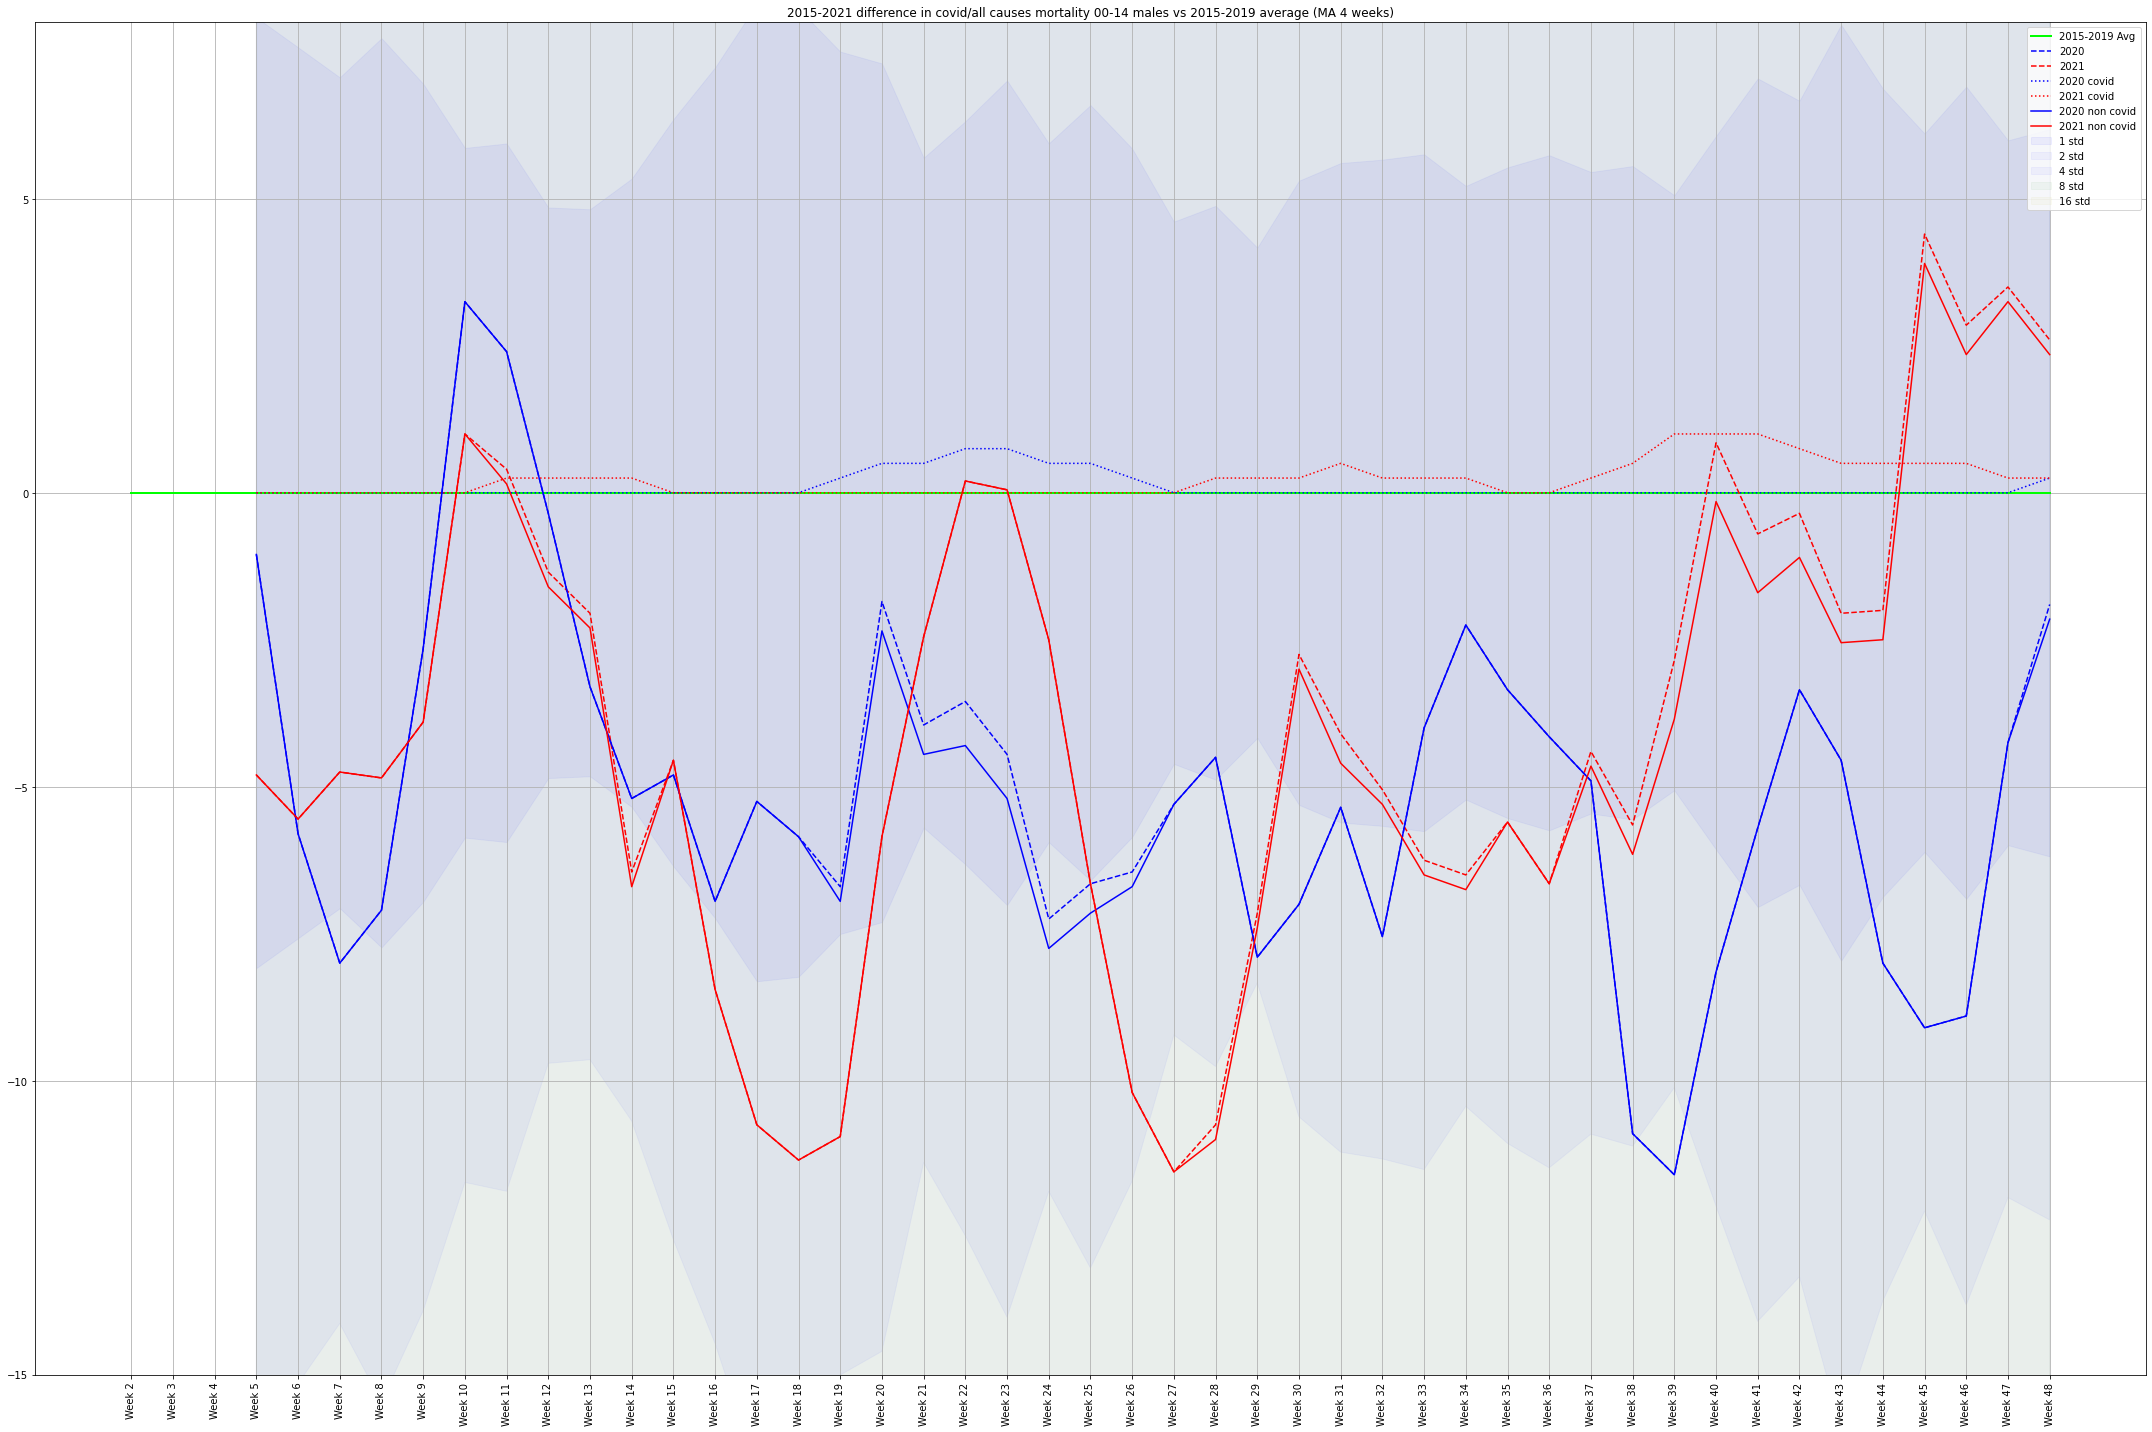

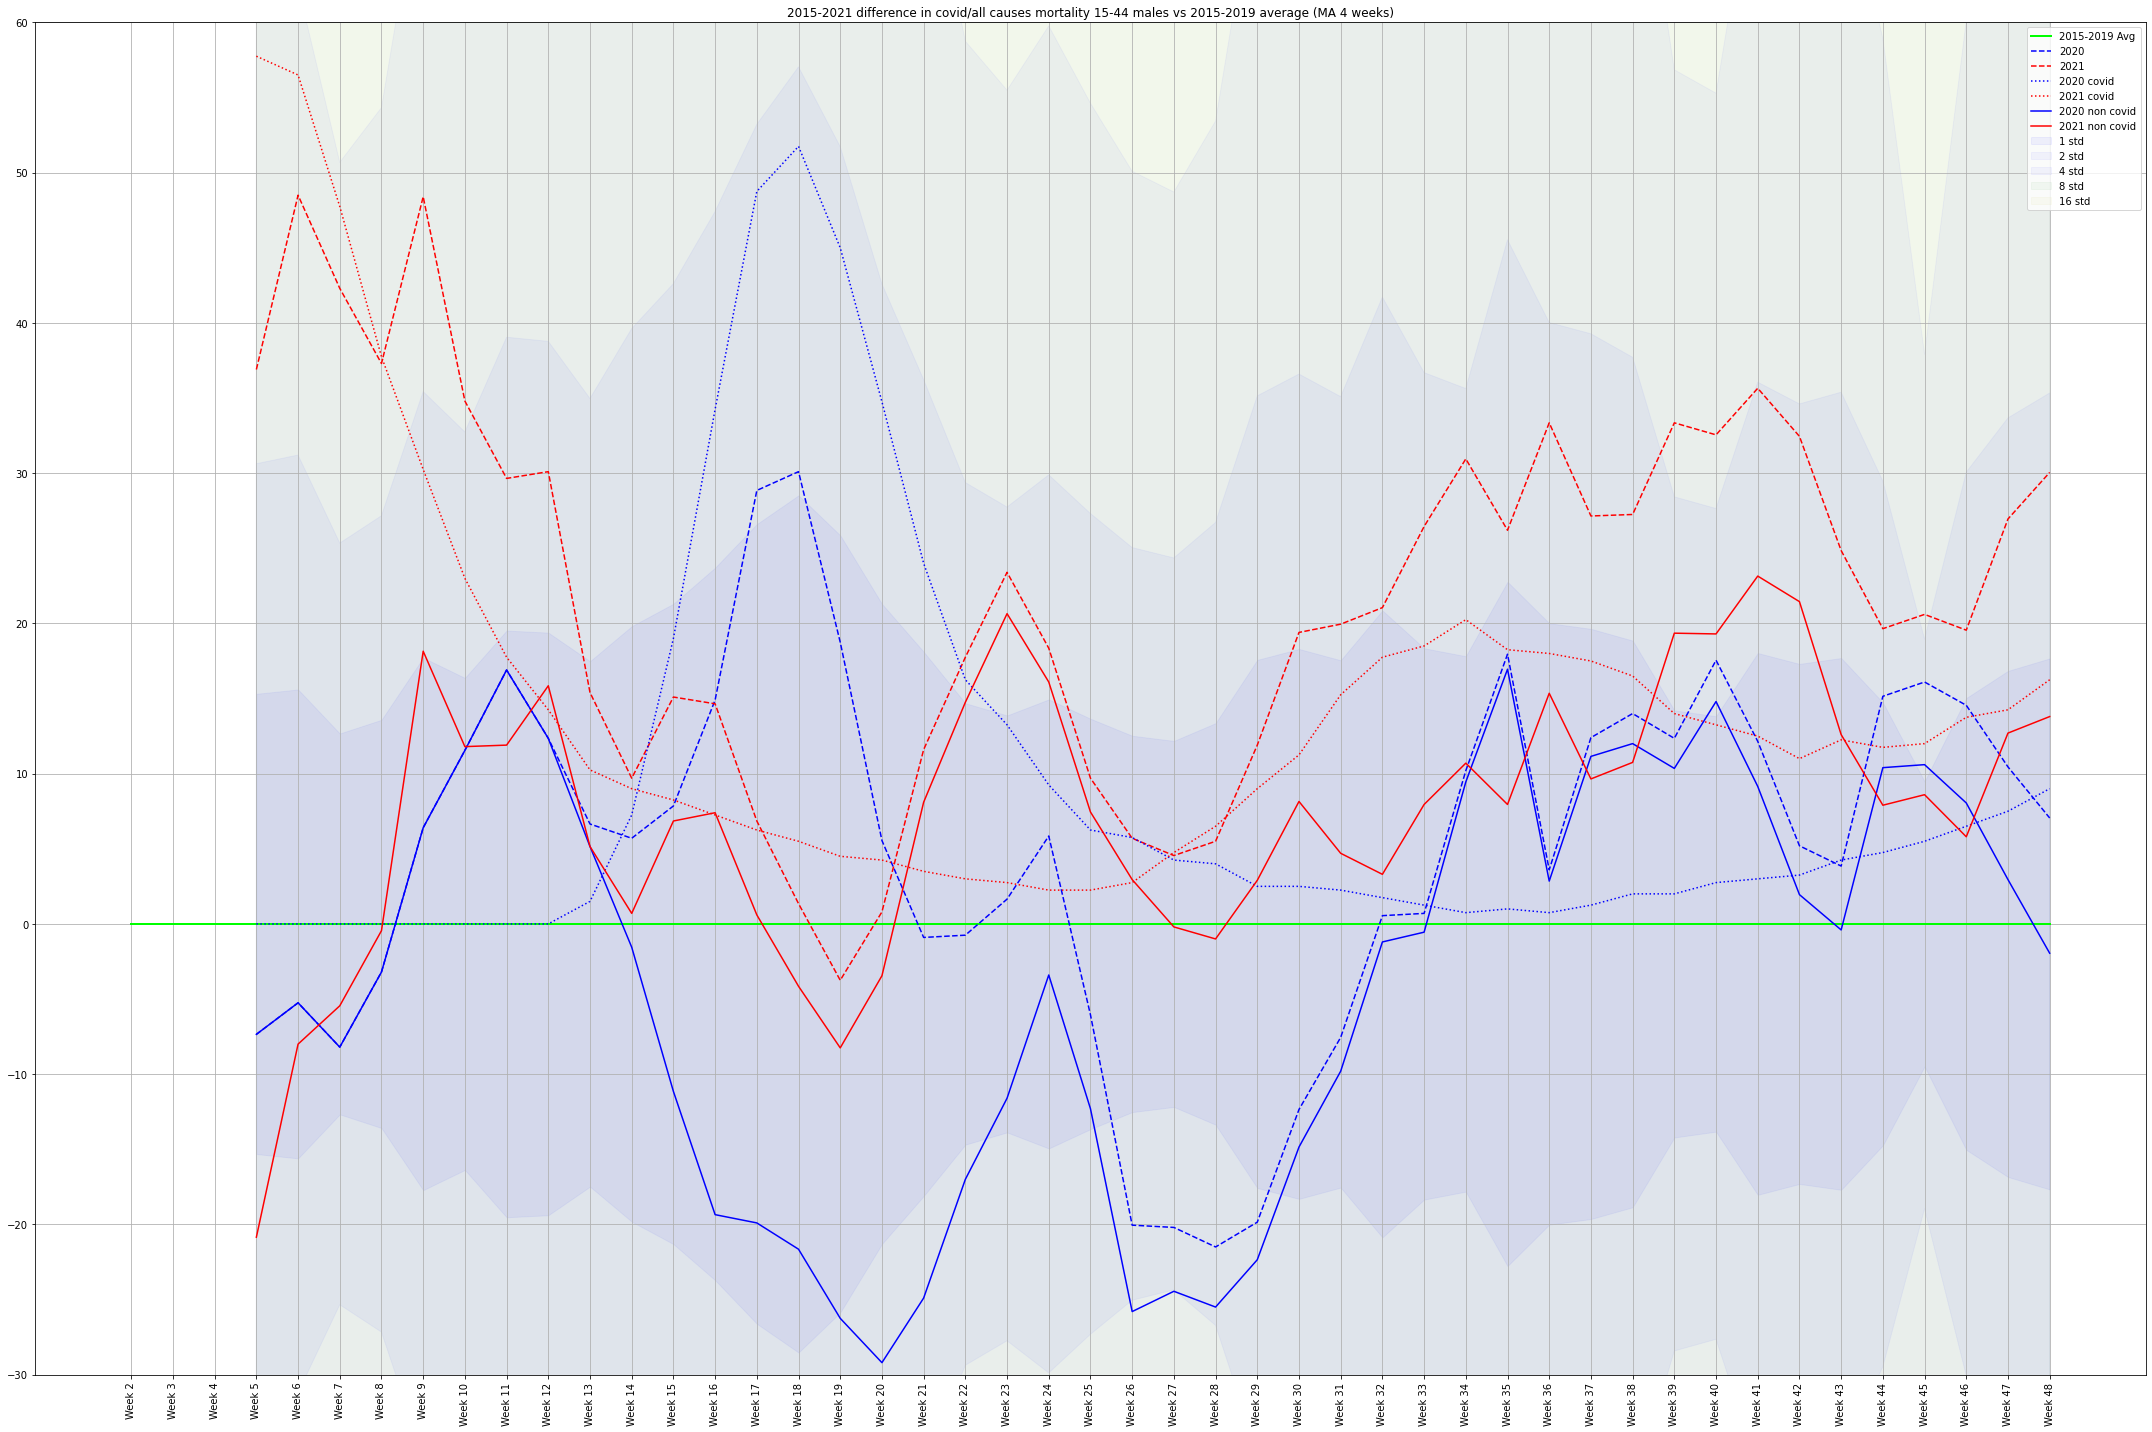

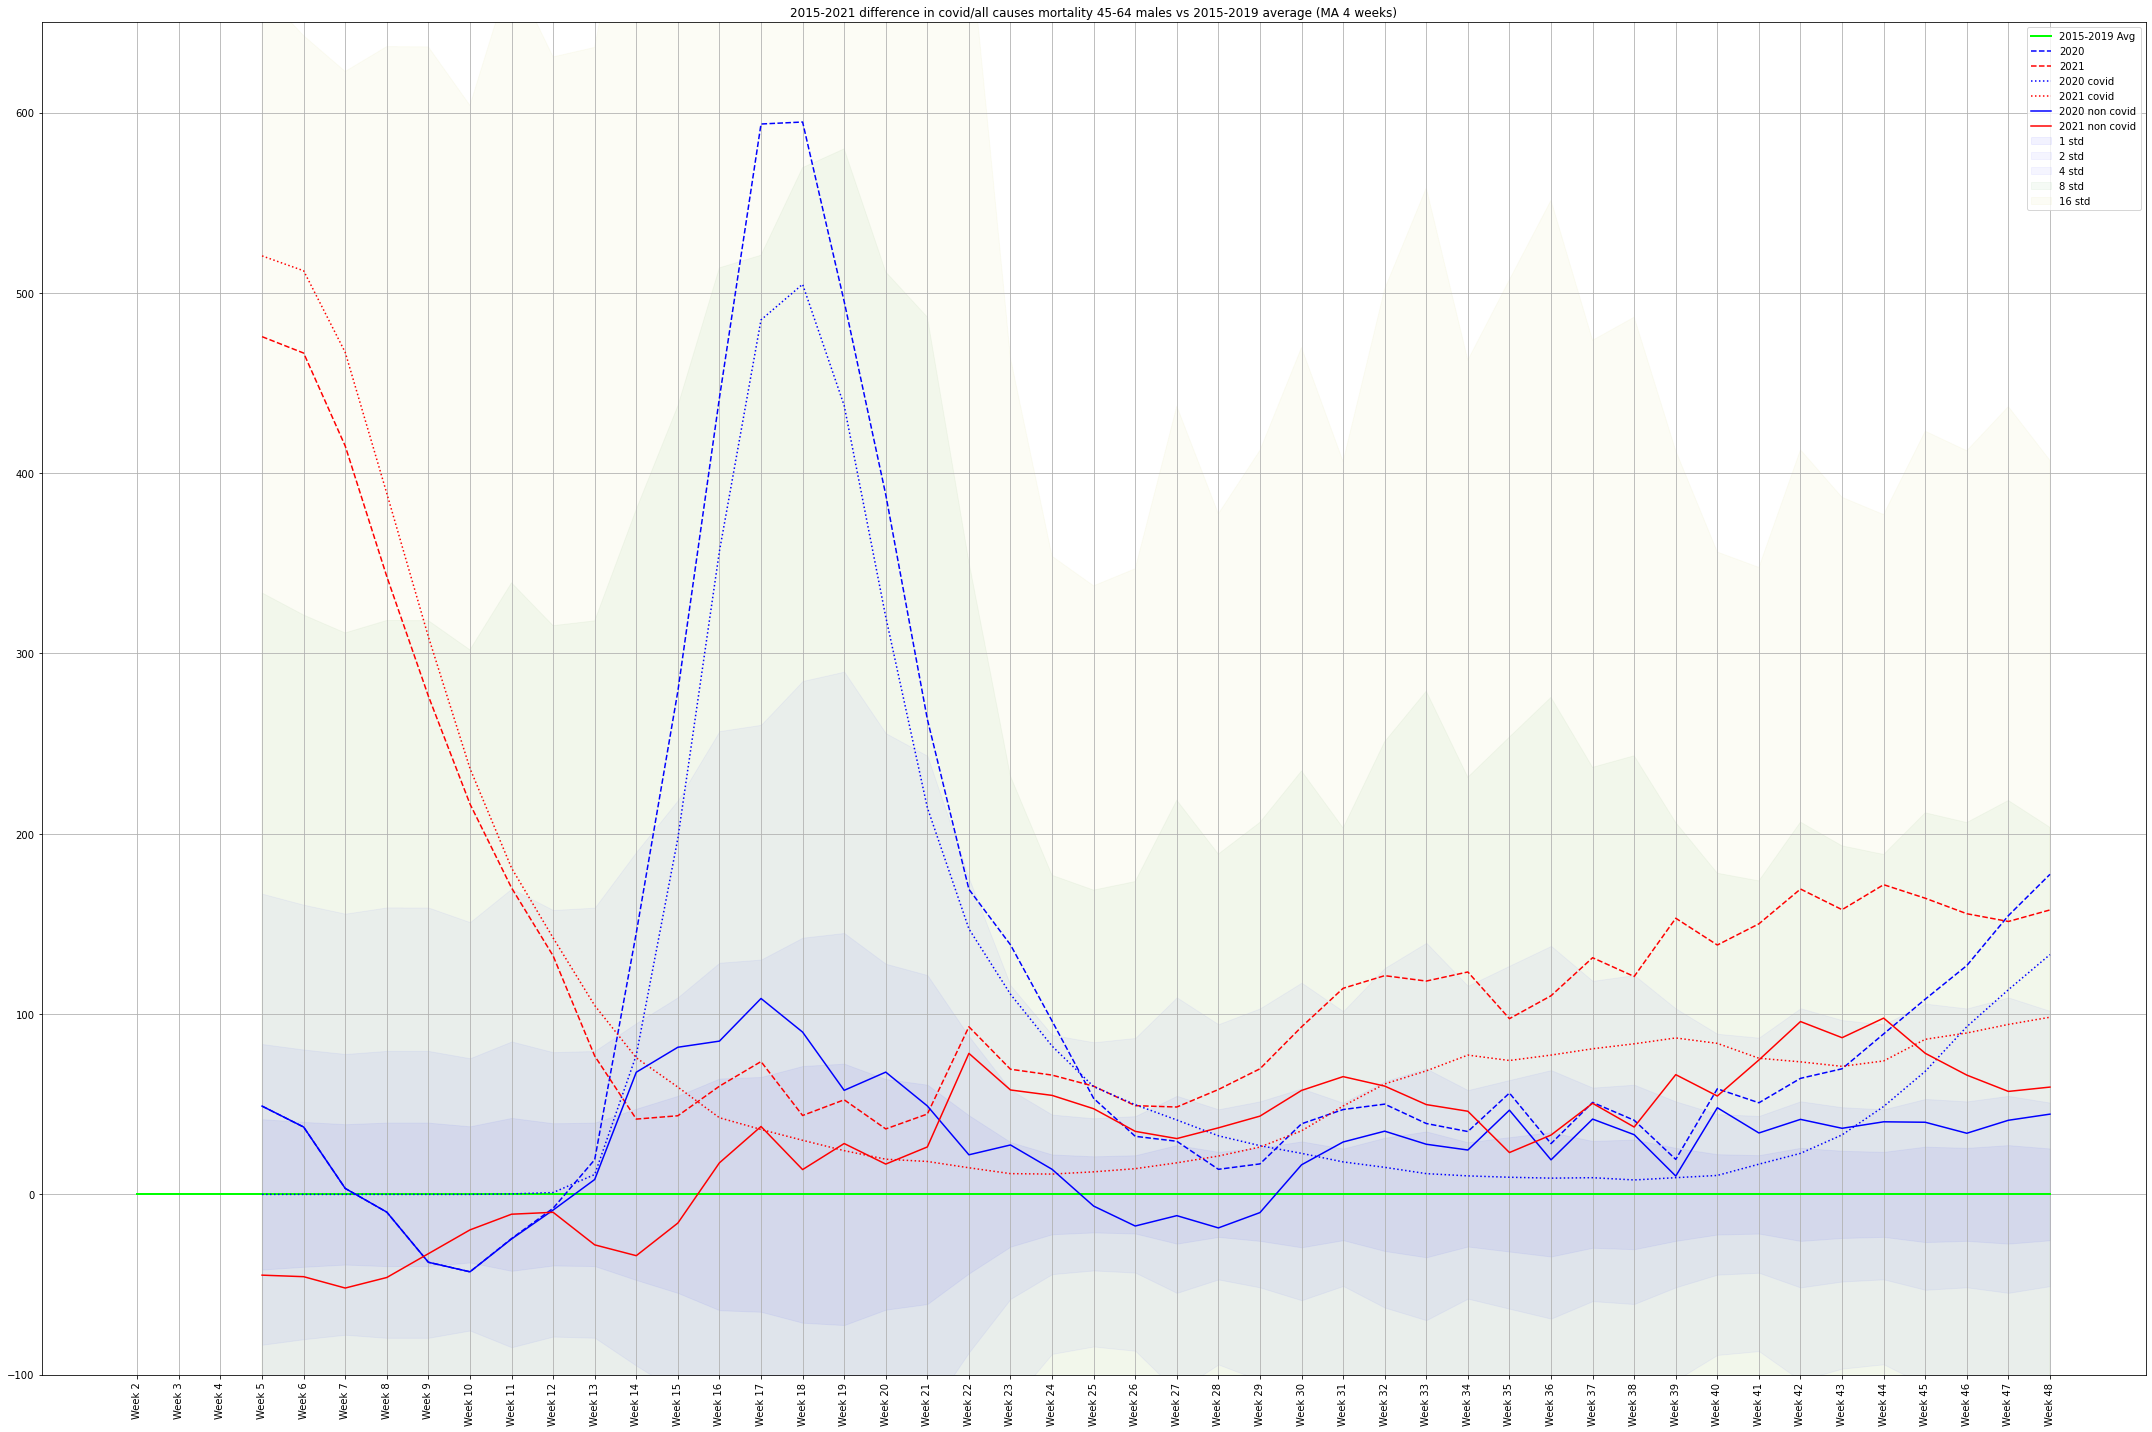

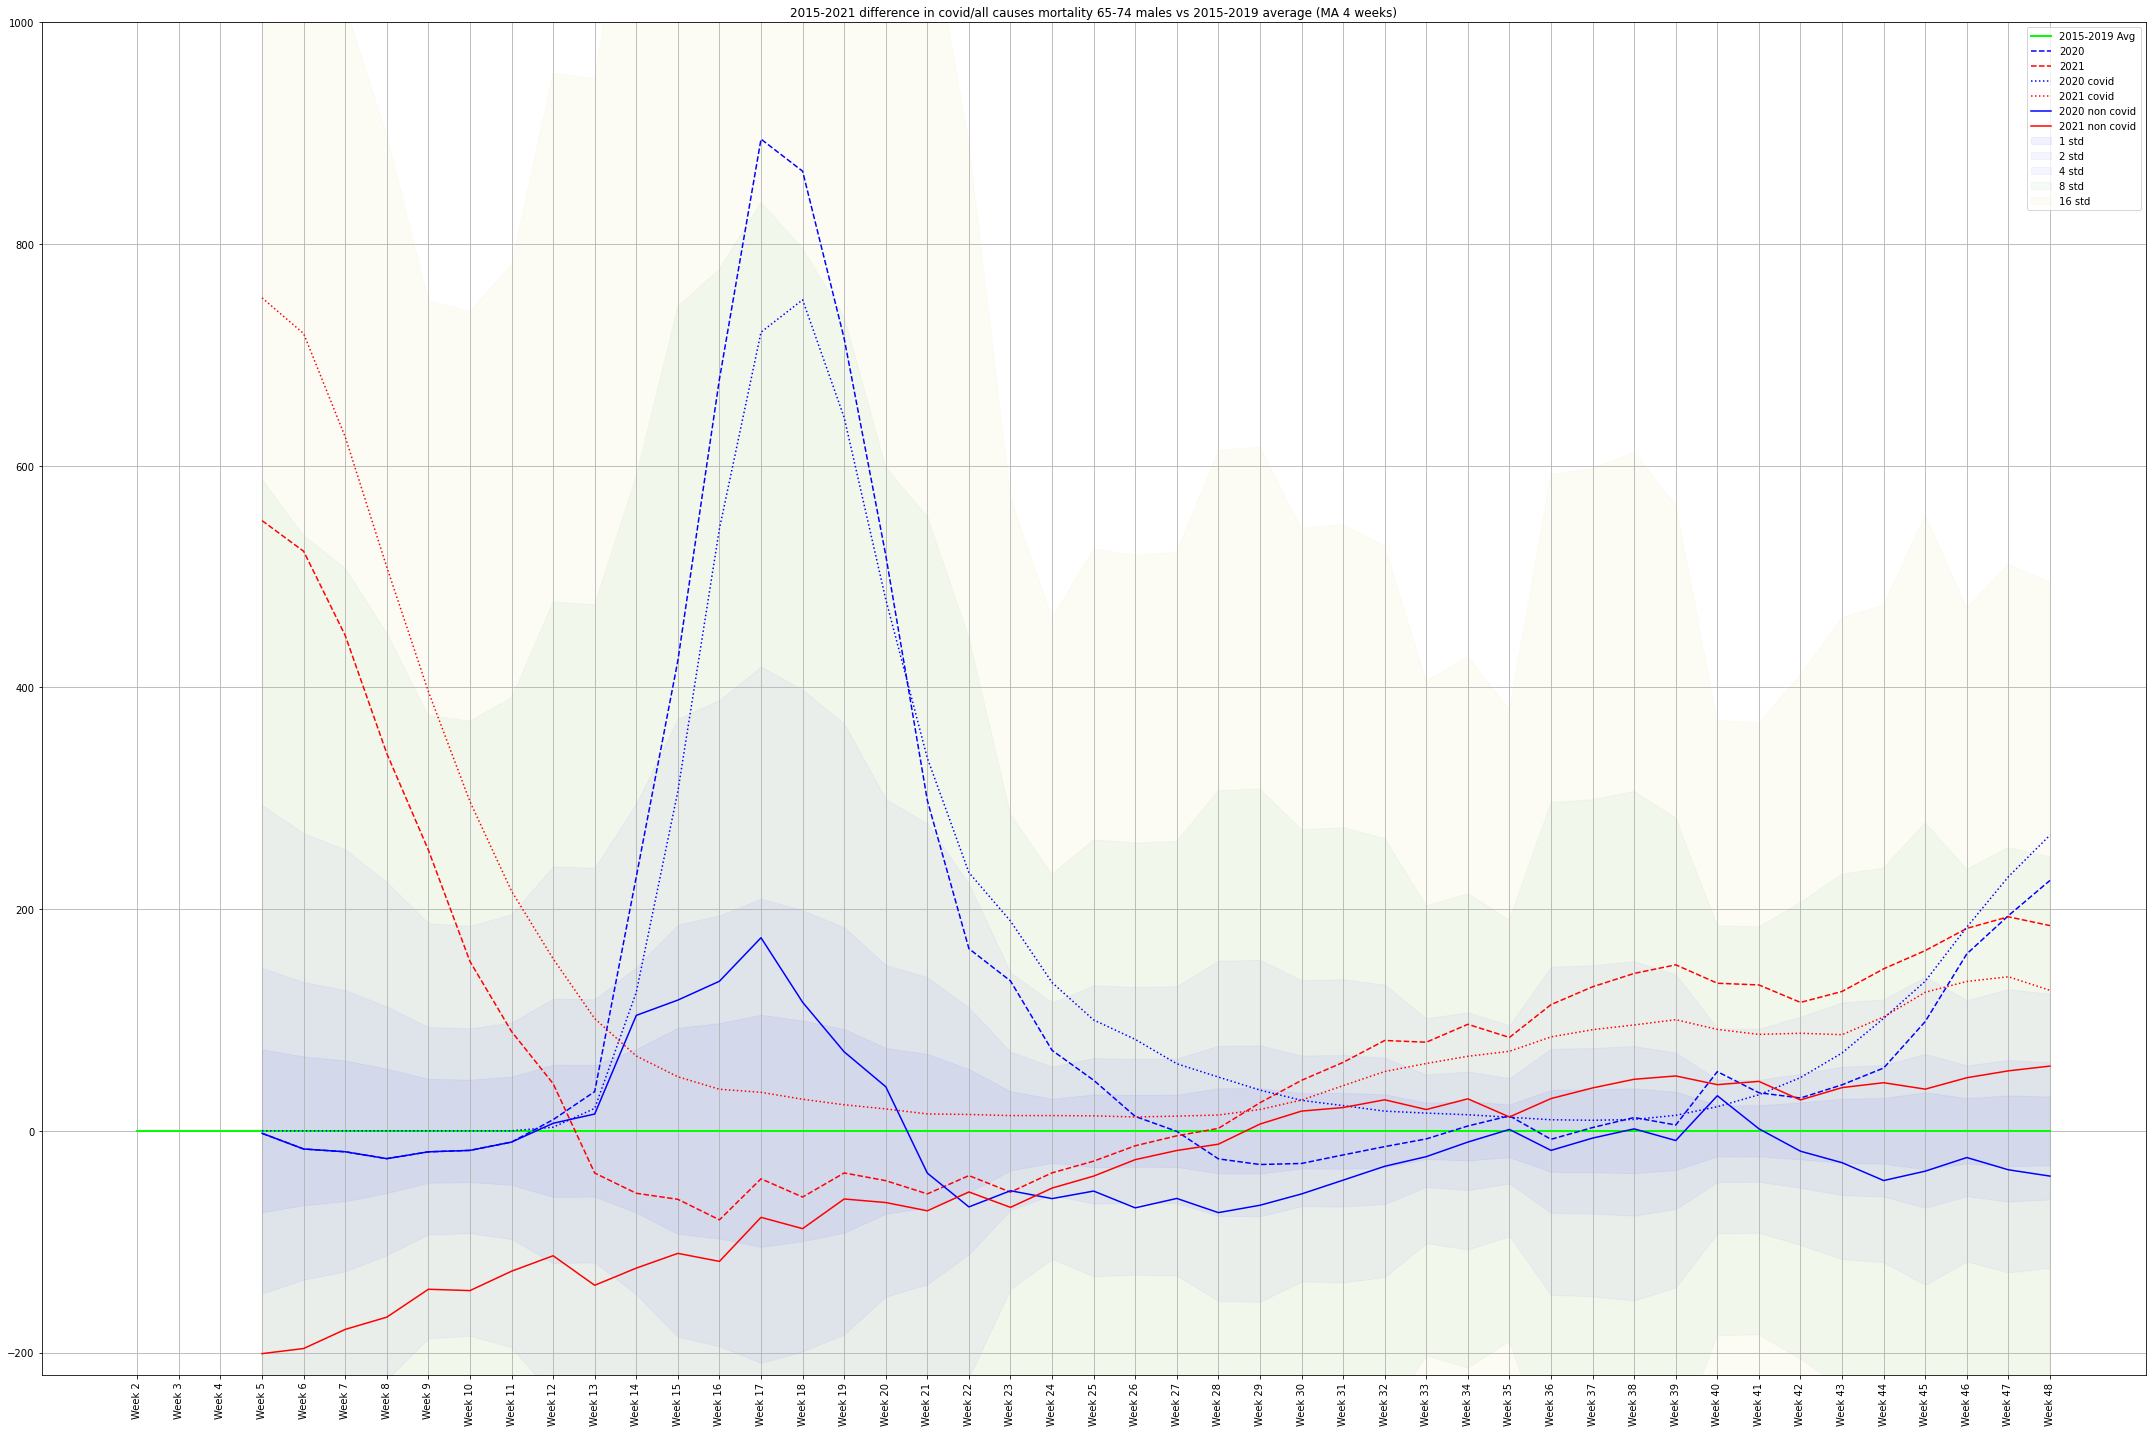

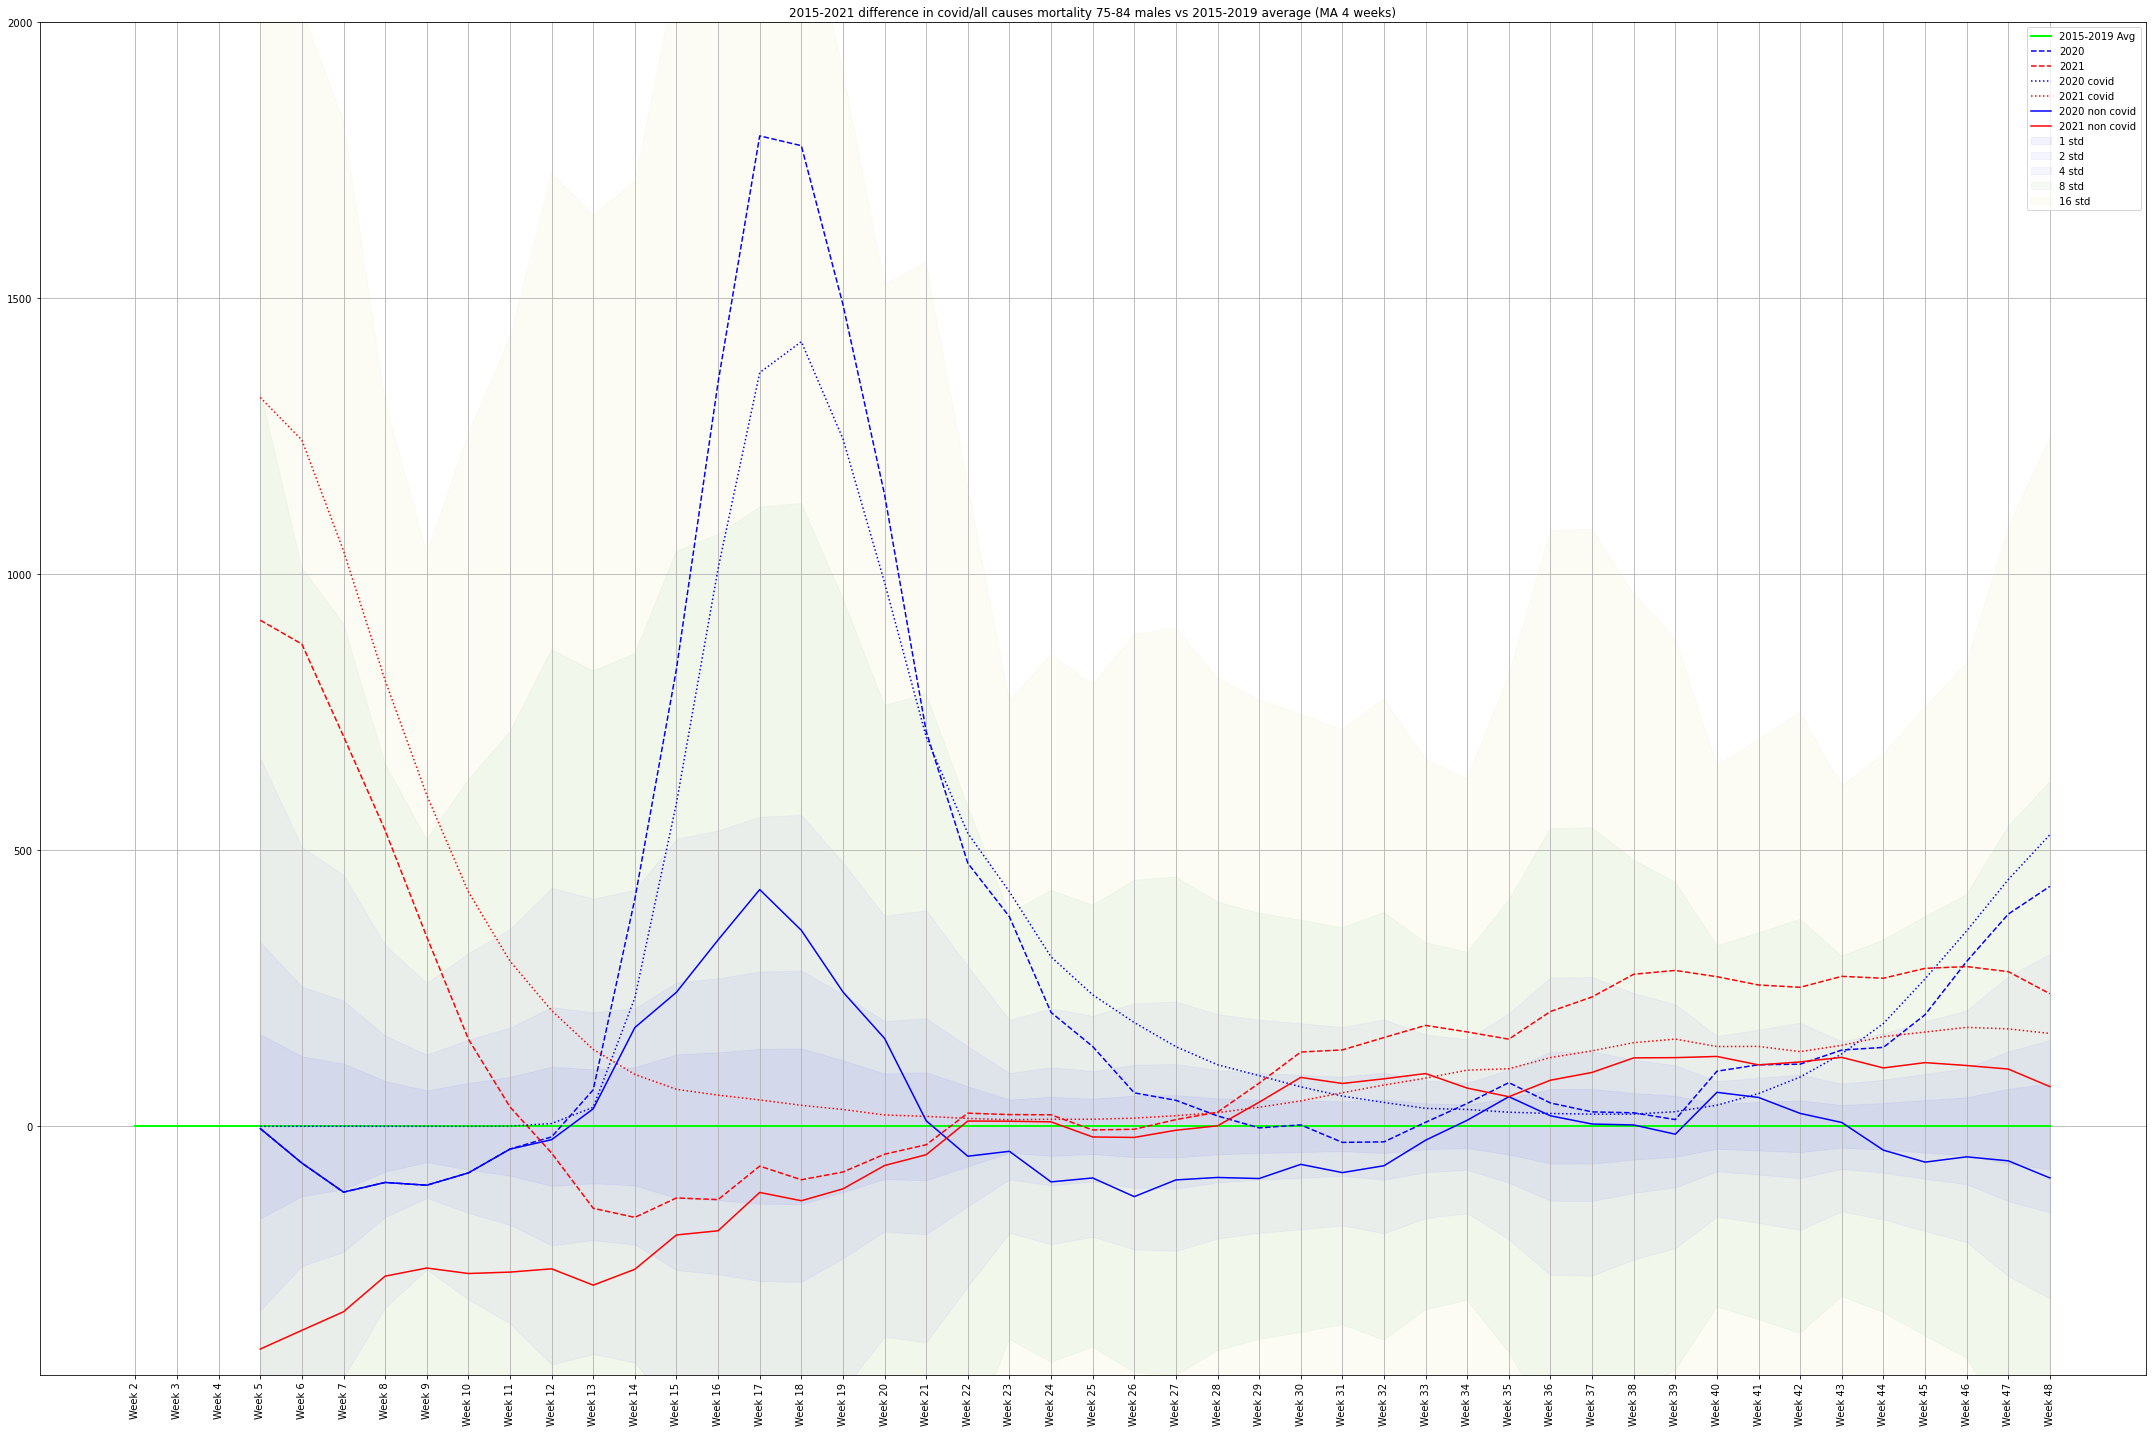

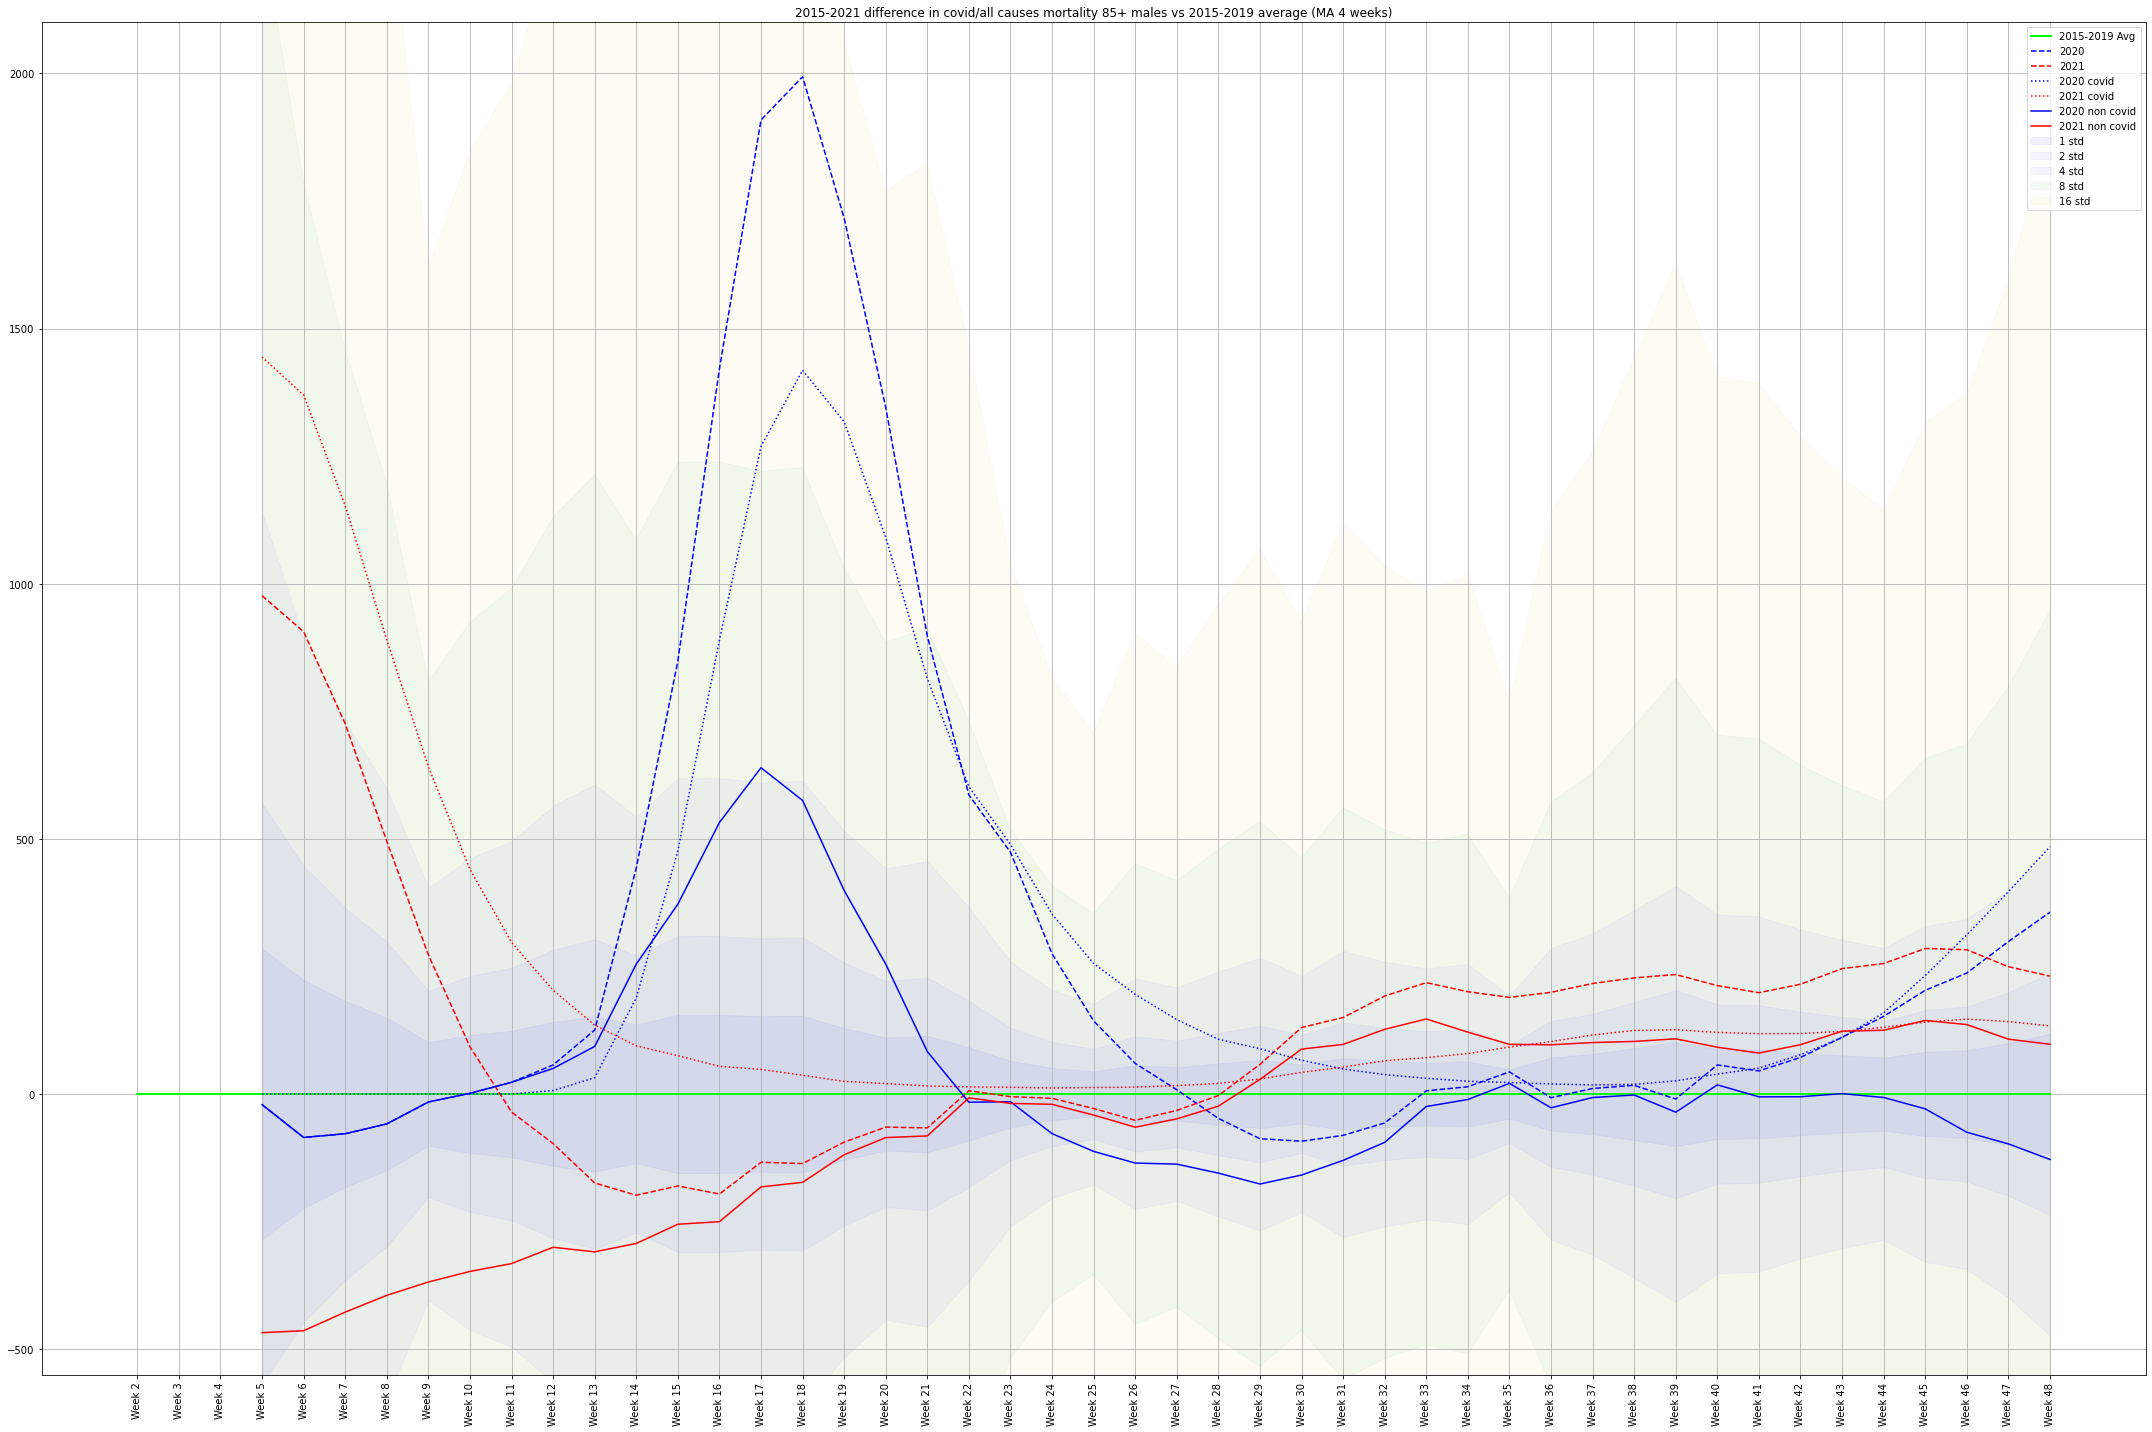

In [51]:
ylims = [(-15, 8), (-30, 60), (-100, 650), (-220, 1000), (-450, 2000), (-550, 2100)]

for age, yl in zip(ages, ylims):

    ax = plt.figure()

    # yes, this is all zero
    ax = plt.plot(avg.index, avg-avg, 'lime', alpha=1, label = '2015-2019 Avg', lw=2)

    ma = uk_2015_2019_avg_MA.loc[age, 'Week 2':end_week]
    mstd = uk_2015_2019_std_MA.loc[age, 'Week 2':end_week]

    for (year,df_src), color in zip(datasets_2020_2021.items(), ['b','r']):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]

        diff = val_MA - ma
        plt.plot(val_MA.index, diff, color, linestyle='dashed', alpha=1, label=f"{year}")

    for (year,df_src), color in zip(datasets_covid_2020_2021.items(), ['b','r']):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]

        #diff = val_MA - ma
        plt.plot(val_MA.index, val_MA, color, linestyle='dotted', alpha=1, label=f"{year} covid")

    for (year,df_src), color in zip(datasets_non_covid_2020_2021.items(), ['b','r']):

        val = df_src.loc[age, 'Week 2':end_week]

        df_src_MA = df_src.iloc[:,1:].rolling(axis=1, window=4).mean()
        val_MA = df_src_MA.loc[age, 'Week 2':end_week]

        diff = val_MA - ma
        plt.plot(val_MA.index, diff, color, alpha=1, label=f"{year} non covid")
        

    #plt.plot(ma.index, ma, 'lime', label="2015-2019 Avg (MA4)", lw=4)
    plt.fill_between(mstd.index, -1*mstd, 1*mstd, color='b', alpha=0.05, label="1 std")
    plt.fill_between(mstd.index, -2*mstd, 2*mstd, color='b', alpha=0.04, label="2 std")
    plt.fill_between(mstd.index, -4*mstd, 4*mstd, color='b', alpha=0.04, label="4 std")
    plt.fill_between(mstd.index, -8*mstd, 8*mstd, color='g', alpha=0.04, label="8 std")
    plt.fill_between(mstd.index, -16*mstd, 16*mstd, color='y', alpha=0.04, label="16 std")
    
    plt.ylim(yl)
    
    plt.title(f"2015-2021 difference in covid/all causes mortality {age} males vs 2015-2019 average (MA 4 weeks)")

    plt.xticks(rotation=90)
    plt.legend()

    plt.grid()
    plt.tight_layout()

    plt.savefig(f"results/diff_non_covid_chart_age_{age}.png", facecolor='white', transparent=False)

    plt.show()